In [121]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFTGate  
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit.library.basis_change import QFT
from neqr import neqr
from ladder import ladder_up
from enhanced_grover import filter_oracle
from qsubtract import subtract
from qadd import qft_adder

In [122]:
num_bits = 1
intensity_bits =  2


In [123]:
image = np.array([
    [0, 1],
    [3, 2]
])

In [124]:
x = QuantumRegister(num_bits, name='x')
y = QuantumRegister(num_bits, name='y')
i1 = QuantumRegister(intensity_bits, name='I₁')
i2 = QuantumRegister(intensity_bits, name='I₂')
grad1 = QuantumRegister(intensity_bits, name='Grad1')
oracle_a = QuantumRegister(1, name = 'oracle_a')
grad2 = QuantumRegister(intensity_bits, name='Grad2')
grad2c = QuantumRegister(1, name='Grad2c')
anc = QuantumRegister(1, name='a')
anc2 = QuantumRegister(1, name = 'a2')
cr = ClassicalRegister(num_bits*2 + intensity_bits +6, name='c')

In [125]:
qc = QuantumCircuit(x, y, i1, i2, grad1,  grad2, grad2c, anc, anc2, oracle_a, cr)


In [126]:
qc.h(x)
qc.h(y)
qc.barrier()


CircuitInstruction(operation=Instruction(name='barrier', num_qubits=14, num_clbits=0, params=[]), qubits=(<Qubit register=(1, "x"), index=0>, <Qubit register=(1, "y"), index=0>, <Qubit register=(2, "I₁"), index=0>, <Qubit register=(2, "I₁"), index=1>, <Qubit register=(2, "I₂"), index=0>, <Qubit register=(2, "I₂"), index=1>, <Qubit register=(2, "Grad1"), index=0>, <Qubit register=(2, "Grad1"), index=1>, <Qubit register=(2, "Grad2"), index=0>, <Qubit register=(2, "Grad2"), index=1>, <Qubit register=(1, "Grad2c"), index=0>, <Qubit register=(1, "a"), index=0>, <Qubit register=(1, "a2"), index=0>, <Qubit register=(1, "oracle_a"), index=0>), clbits=())

In [127]:
neqr_gate1 = neqr(i1,x,y,image)
qc.append(neqr_gate1, list(i1) + list(x) + list(y))


In [128]:
# Shift up: ladder_up
ladder = ladder_up(x)
qc.append(ladder, list(x))

In [129]:
qc.append(neqr_gate1, list(i2) + list(x) + list(y))
ladder_down = ladder.inverse()


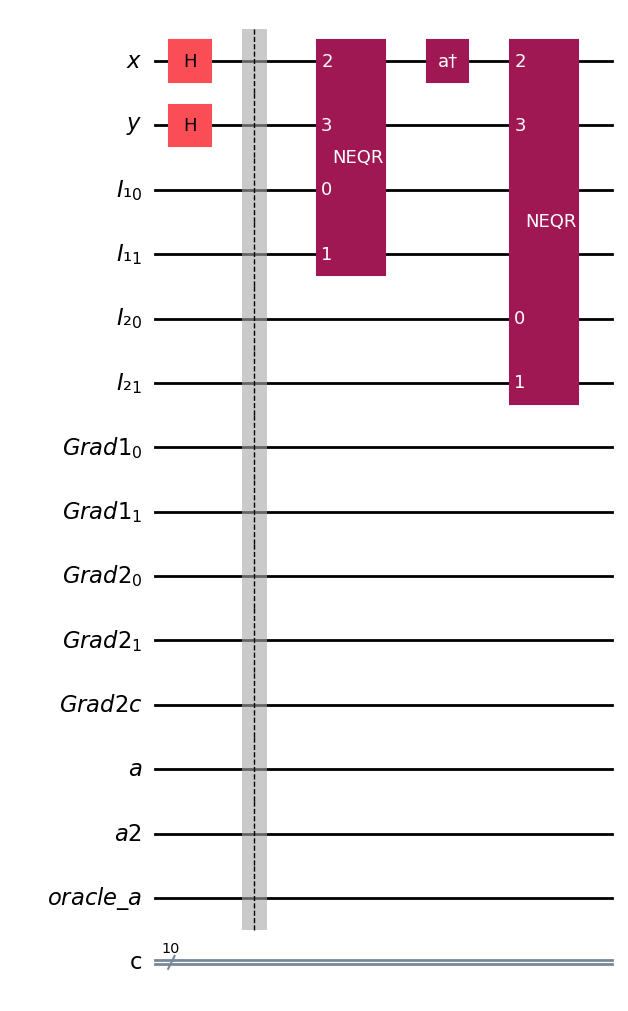

In [130]:
qc.draw('mpl')

In [131]:
#qc.measure(list(x) + list(y) + list(i1) + list(i2), list(cr))

In [132]:
for i in range(intensity_bits):
    qc.cx(i2[i], grad1[i])

In [133]:
sub1 = subtract(i1, grad1, anc)
qc.append(sub1, list(i1) + list(grad1) + list(anc))

In [134]:
neqr1_inverse = neqr_gate1.inverse()
qc.append(neqr1_inverse, list(i2) + list(x) + list(y))

In [135]:
ladder_down = ladder.inverse()
qc.append(ladder_down,list(x))
qc.append(ladder, list(y))

In [136]:
qc.append(neqr_gate1, list(i2) + list(x) + list(y))

In [137]:
qc.append(ladder_down,list(y))

In [138]:
for i in range(intensity_bits):
    qc.cx(i2[i], grad2[i])

In [139]:
qc.append(sub1, list(i1) + list(grad2) + list(anc2))


In [140]:
add = qft_adder(grad1,grad2,grad2c)
qc.append(add, list(grad1) + list(grad2) + list(grad2c))

In [141]:
full_g2 = list(grad2) + list(grad2c)
qc.h(oracle_a)

og = filter_oracle("010")
cog = og.control(1,label="Og")
qc.append(cog, list(oracle_a) + list(grad2) + list(grad2c))

qc.h(oracle_a)

3
[0, 1, 0]
2 0
max 2
1 1
0 0


In [142]:
qc.measure(list(x) + list(y) + list(i1) + list(grad1) + list(grad2) + list(grad2c) + list(oracle_a), list(cr))

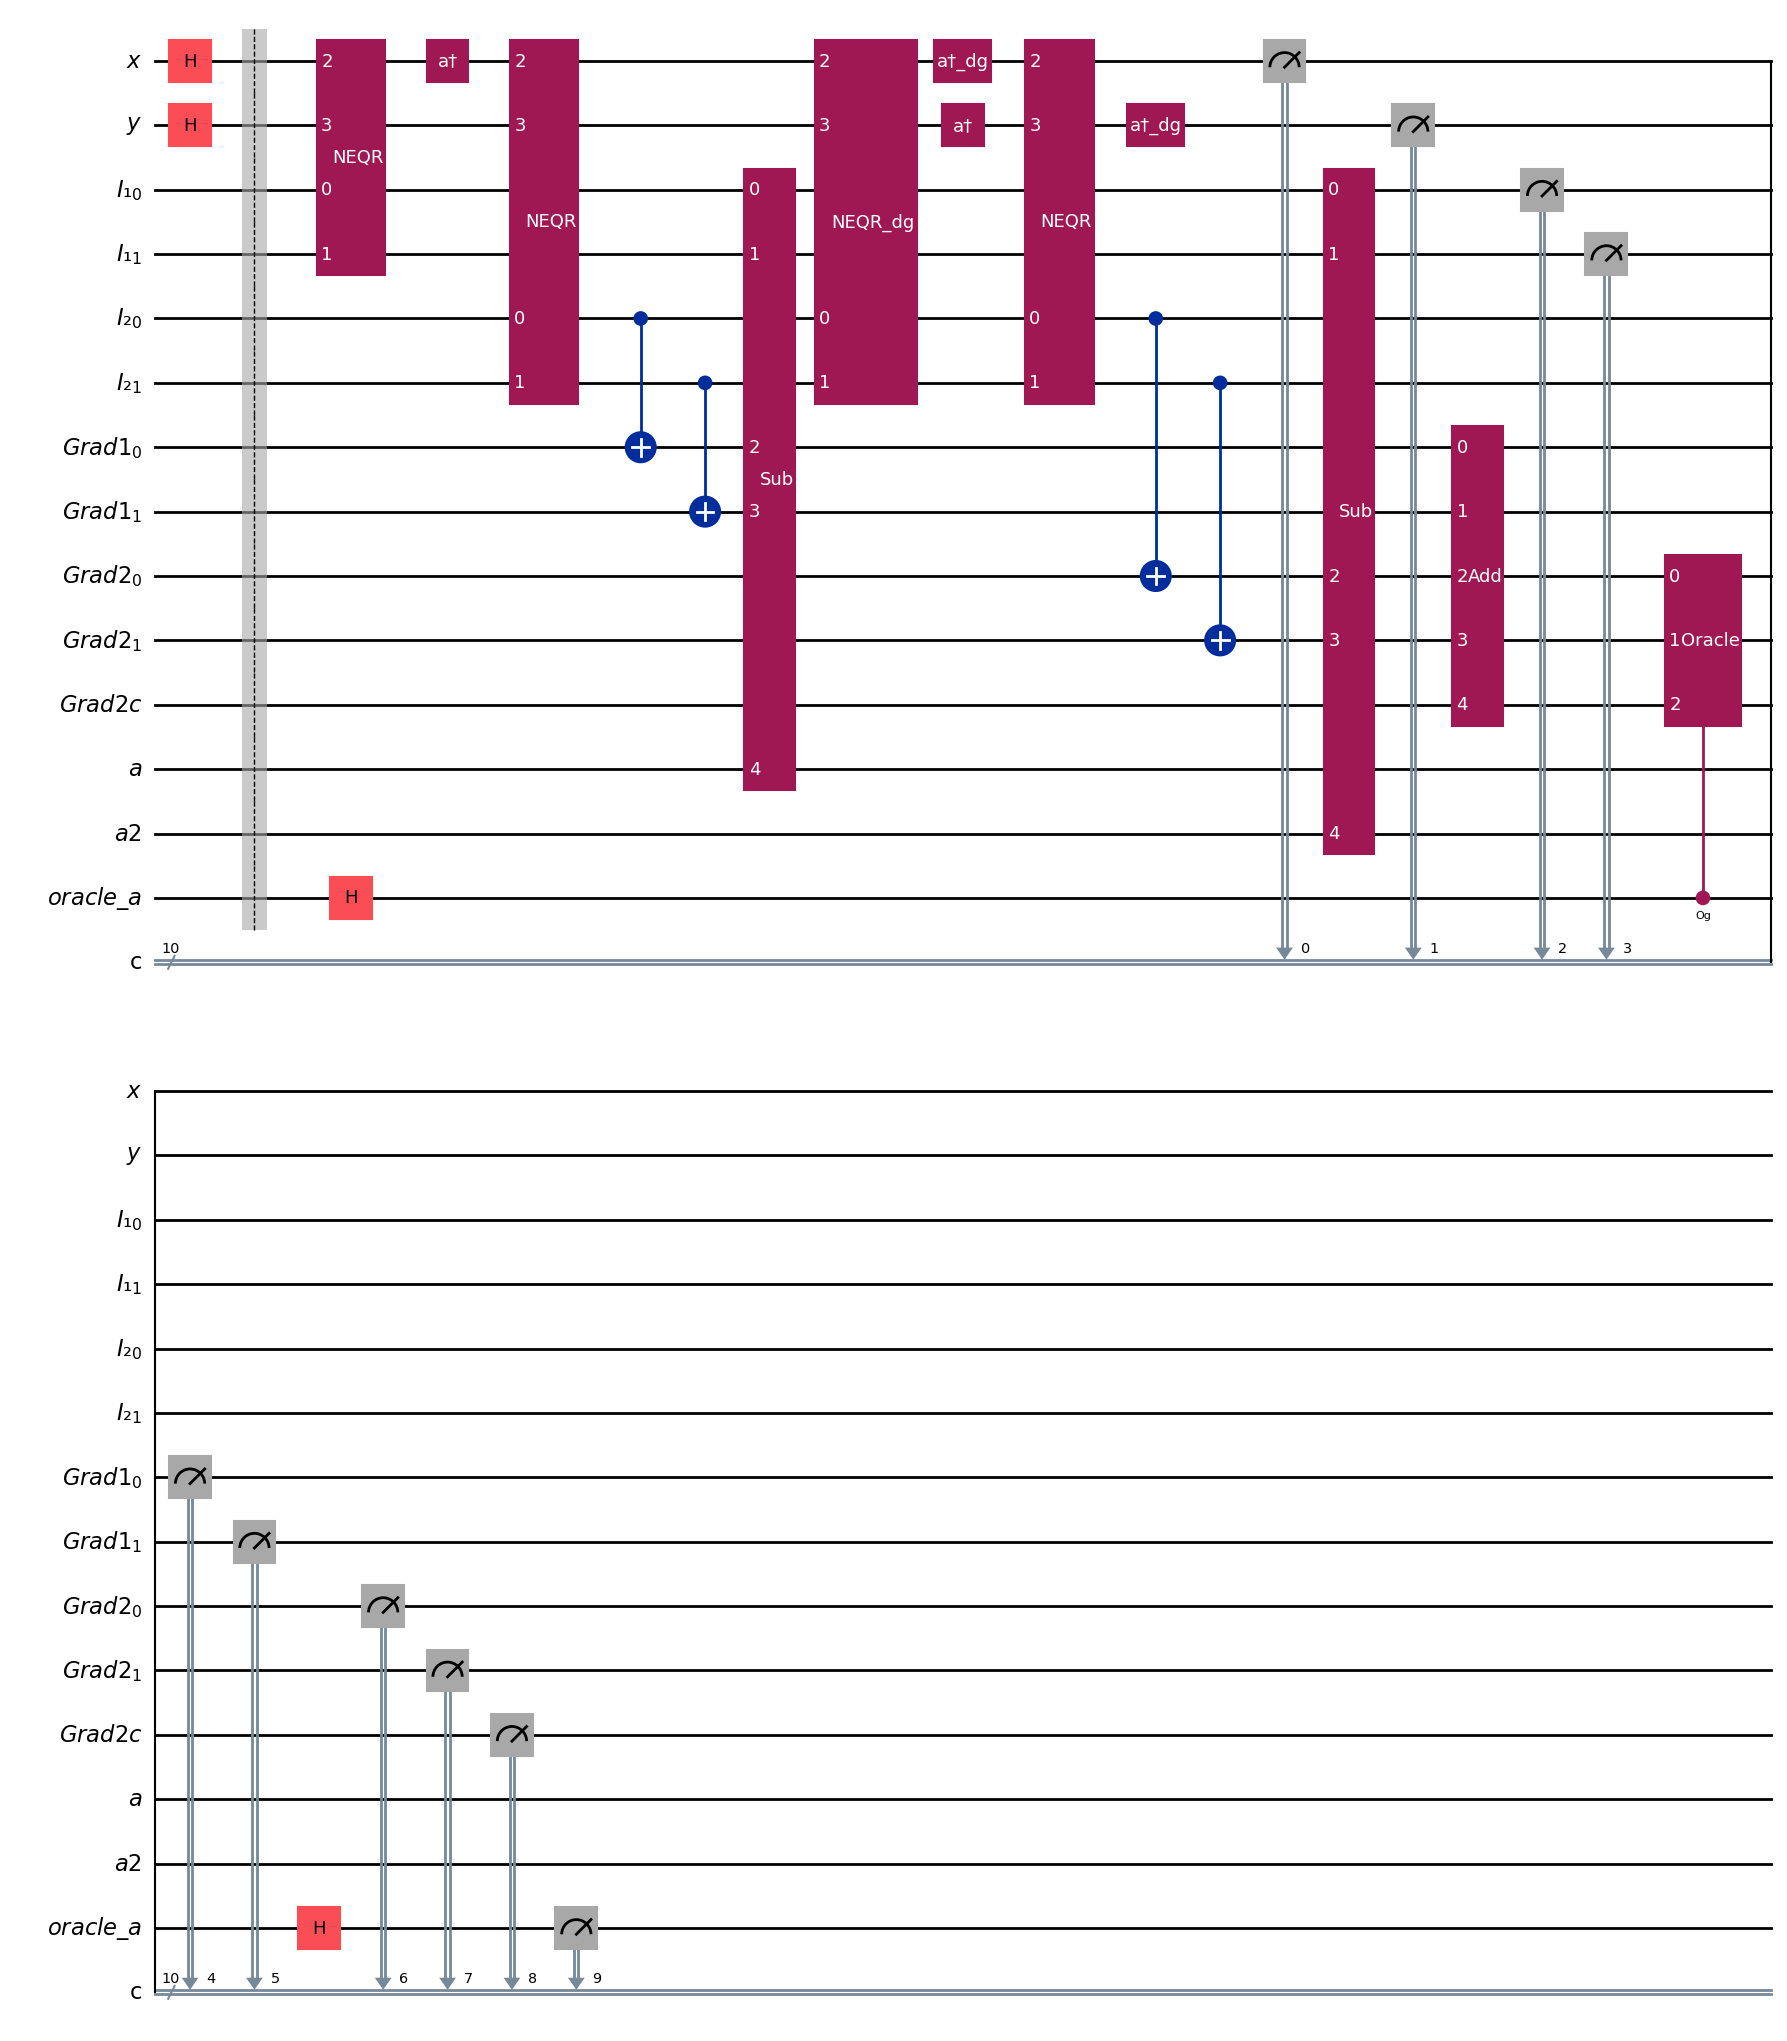

In [143]:
qc.draw('mpl')

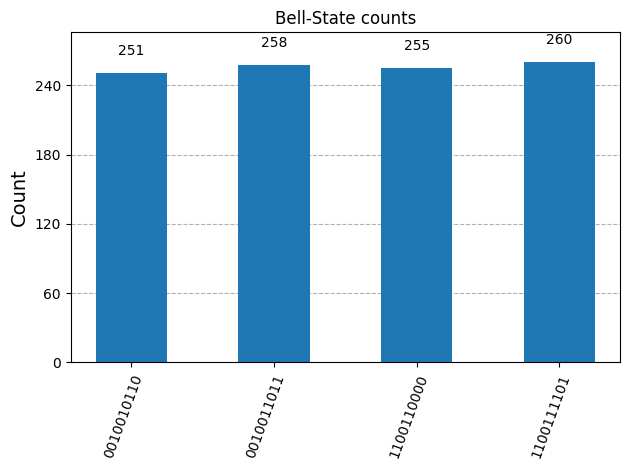

In [144]:
simulator = AerSimulator()
circ = transpile(qc, simulator)

result = simulator.run(circ).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Bell-State counts')